Much of this lecture follows the free textbook by Rob Hyndman, [Forecasting Principles and Practice](https://otexts.org/fpp2/)

## Objectives

By the end of the day you should be able to:

  - Define "time series" and "time-series data".
  - Identify fundamental concepts in a time series: trend, seasonality, stickyness.
  - Use the classical decomposition to decompose and then describe a time series.
  - Define stationarity, contrast with independence.
  - Identify a stationary time series.
  - Fit ARIMA models to forecast a stationary time series.

## Agenda

#### Morning
 * Some examples
 * Trend
 * Seasonality


#### Afternoon
 * White noise & Stationarity
 * Differencing
 * Random walks
 * MA series
 * Autocorrelation
 * Partial autocorrelation
 * Autoregressive series
 * ARIMA models
 * Model selection

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Always make it pretty.
plt.style.use('ggplot')

# Time Series fundamentals: Trends & Seasonality

A *time series* is a specific type of data, where measurements of a single quantity are taken over time.

When speaking in equations, we will generally represent time with an index $i$, and the observations from the series as $y_i$.  So the time series as a whole is

$$y_1, y_2, y_3, \ldots $$

### Examples

A good source for time series data is [google trends](https://www.google.com/trends/) where you can find how the popularity of a search term varies over time:

We've provided some chosen google trends in the `data` directory.

In [2]:
def load_google_trend_data(name):
    """Load saved data for a google trend.
    
    NOTE: For this to work you need to have started your notebook from the
    lecture directory.
    """
    file_name = 'data/{}'.format(''.join(['search-index-', name, '.txt']))
    df = pd.read_csv(file_name)
    df = df.set_index(pd.DatetimeIndex(df.week))
    del df['week']
    return pd.Series(df[name], df.index)

Let's plot these trends and look for some interesting patterns.

In [3]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series, marker='.')
    ax.set_title("Google Search Trend For {}".format(name))

In [4]:
google_search_names = ['baseball', 'python', 'pokemon', 'taxes', 'gdp', 'gmail', 'blackberry', 'data-science']

google_trends = {
    name: load_google_trend_data(name)
    for name in google_search_names
}

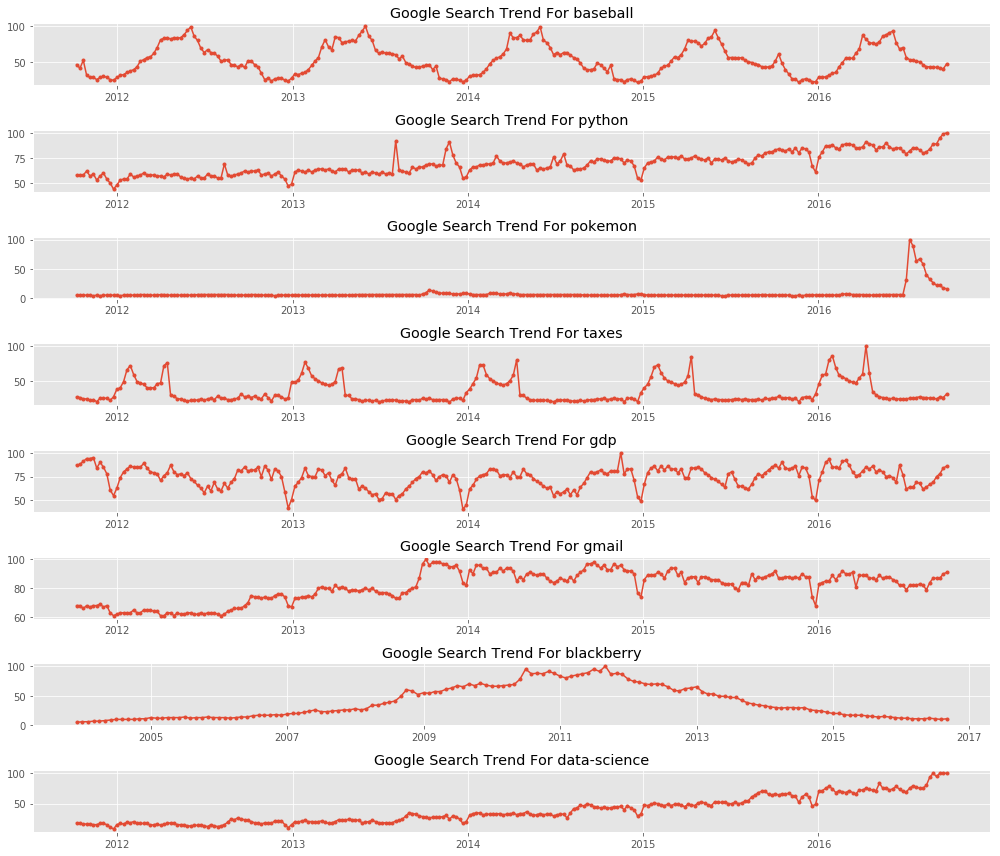

In [5]:
fig, axs = plt.subplots(len(google_trends), figsize=(14, 12))

for ax, name in zip(axs, google_search_names):
    plot_trend_data(ax, name, load_google_trend_data(name))
    
plt.tight_layout()

Some observations:

  - Searches for **baseball** show very strong oscillations aligned with the baseball season.  Search volume increases quickly as the season begins, and then falls off as the season goes on.
  - Searches for **python** show a general increase over time, probably influenced by the popularity of the language itself.  There may be evidence that searches decrease as specific periods of the year, most noticeably the end of year, when people are not working.
  - Searches for **pokemon** spike suddenly at a recent date, pointing to a one-time event greatly increasing interest.
  - Searches for **taxes** spike regularly at two specific points of the year, with the interest being heightened between those two dates.  At other times of the year, searches revert to a low rate.
  - Searches for **gdp** show a more random pattern than the others.  There is some evidence for *stickiness* in the trend, low values beget low subsequent values, and high values beget high subsequent values.
  - Searches for **gmail** show a pattern reminiscent of python, but there are sudden shifts where the baseline level jumps to a new value.
  - Searches for **blackberry** have a non-linear trend over time, they increase to a peak popularity, then decrease to almost nothing.

Let's look the trend data for "data-science" a bit closer. What patterns do you see?

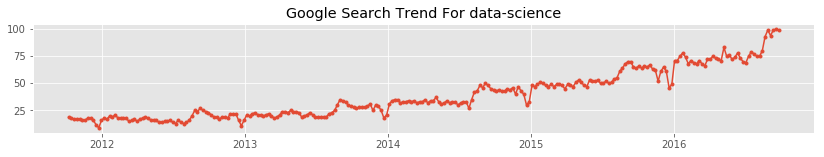

In [6]:
fig = plt.figure(figsize=(14,2))
ax = plt.subplot(111)
plot_trend_data(ax, 'data-science', load_google_trend_data('data-science'))

## Trends

A **trend** in a time series is a gradual change in average level as time moves on.  A trend can be *increasing*, *decreasing*, or *neither* (if, for example, a trend changes direction at some point in time). 

Searches for **python** show a steady increasing trend.

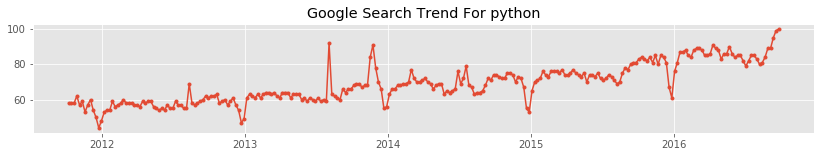

In [7]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'python', google_trends['python'])

Searches for **blackberry** show a non-linear trend.

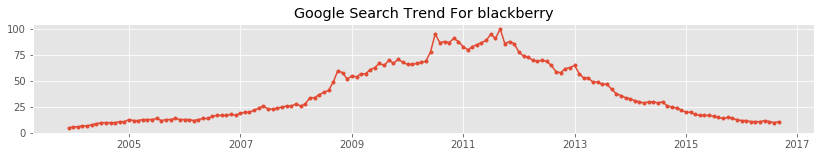

In [8]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'blackberry', google_trends['blackberry'])

**Question:** How you you describe the trend in `data-science`?

You can often use a regression model to capture a general trend in the series.

Let's try to capture the linear trend in the python search data by fitting a simple linear model and using its predictions on the training data.

In [9]:
def make_design_matrix(arr):
    """Construct a design matrix from a 1D numpy array, including an intercept term."""
    return sm.add_constant(arr.reshape(-1,1))

In [10]:
def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

In [11]:
def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)

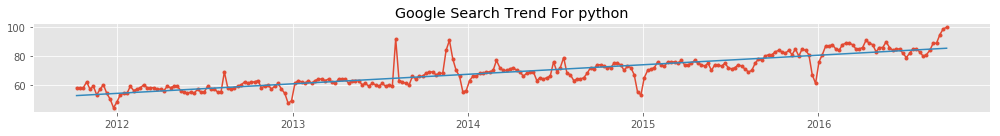

In [12]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_linear_trend(ax, 'python', google_trends['python'])
plt.tight_layout()

If we subtract out the fit trend from the original series, we get the **detrended series**.

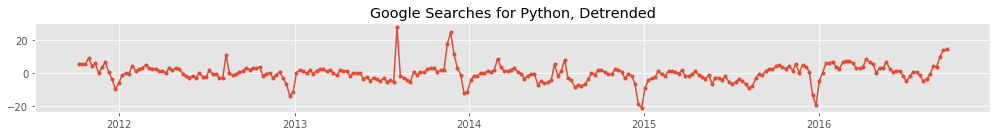

In [13]:
python_series = load_google_trend_data('python')
python_linear_trend = fit_linear_trend(python_series)
python_series_detrended = python_series - python_linear_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(python_series_detrended.index, 
        python_series_detrended,
        marker='.')
ax.set_title("Google Searches for Python, Detrended")
plt.tight_layout()

Detrending a series is often a first step in analyzing a time series.

Often time series show a more sophisticated trend than a simple linear increase or decrease; in these cases a more sophisticated detrending procedure is needed.

In the following two cases, a linear detrending would be clearly inappropriate.

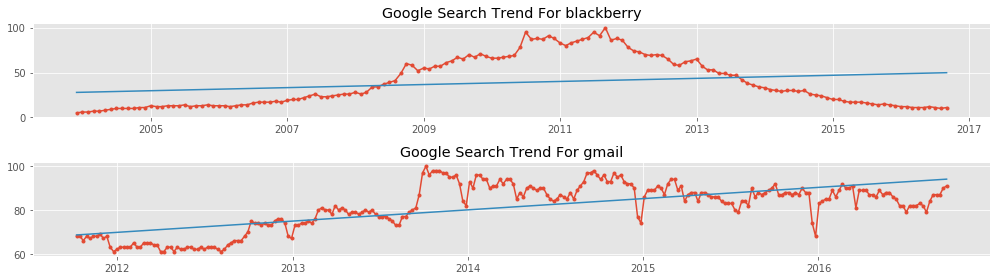

In [14]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_linear_trend(axs[0], 'blackberry', google_trends['blackberry'])
plot_linear_trend(axs[1], 'gmail', google_trends['gmail'])
plt.tight_layout()

**Question:** Can you describe precisely what is wrong with the linear model in both of these cases?

### Moving Average Smoothing

A very general approach that can be used for detrending data is to compute a **moving average**.

The moving average estimate of the trend at a data point $y_i$ is

$$ \hat y_i = \frac{1}{2w + 1} \sum_{j = -w}^{w} y_{i + j} $$

We esentially slide a *window* of a fixed size across our data, and average the values of the series within the window.

The parameter $w$ controls how far to the left and to the right of $w_i$ we look when averaging the nearby points, this is called the **window**.

In [15]:
def fit_moving_average_trend(series, window=6):
    return series.rolling(window=window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend, marker='.')

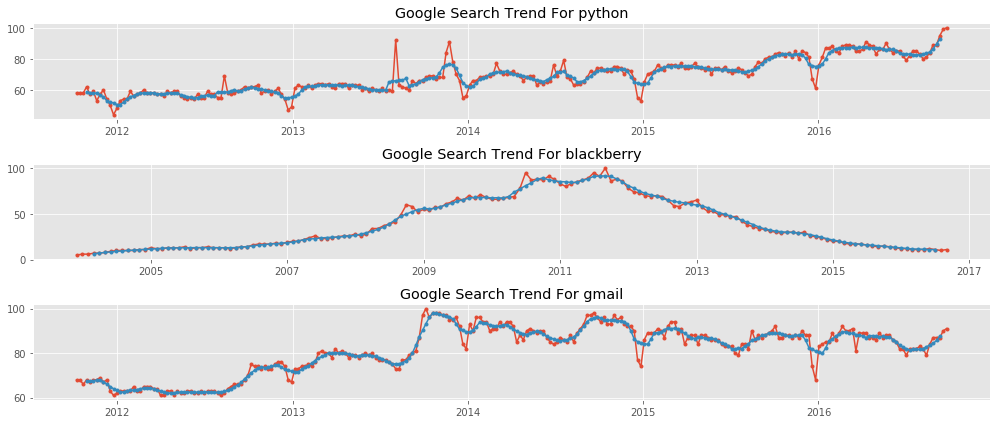

In [16]:
fig, axs = plt.subplots(3, figsize=(14, 6))
plot_moving_average_trend(axs[0], 'python', google_trends['python'])
plot_moving_average_trend(axs[1], 'blackberry', google_trends['blackberry'])
plot_moving_average_trend(axs[2], 'gmail', google_trends['gmail'])
plt.tight_layout()

Varying the window parameter changes the quality of the moving average fit

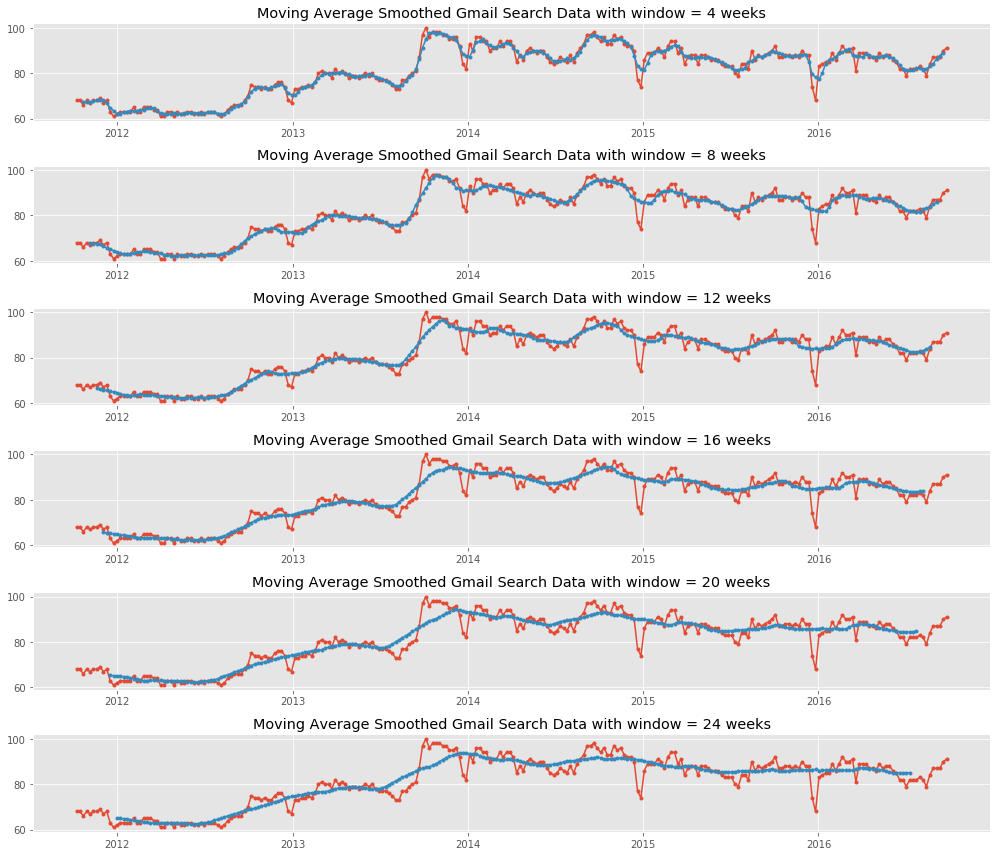

In [17]:
fig, axs = plt.subplots(6, figsize=(14, 12))

gmail_series = google_trends['gmail']
for i, window in enumerate([4, 8, 12, 16, 20, 24]):
    axs[i].plot(gmail_series.index, 
                gmail_series,
                marker='.')
    axs[i].plot(gmail_series.index, 
                fit_moving_average_trend(gmail_series, window=window),
                marker='.')
    axs[i].set_title("Moving Average Smoothed Gmail Search Data with window = {} weeks".format(window))
    
plt.tight_layout()

We see that:

  - Smaller values of `window` will tend to be influenced by noise or other non-trend patterns in the series.
  - Large values of `window` produce smoother estimates of the general trend in the data.
  
For this reason, when estimating the trend component of a time series, we generally prefer larger windows.

**Activity:** Fit a moving average smooth to the data science series for various windows, and plot the results.

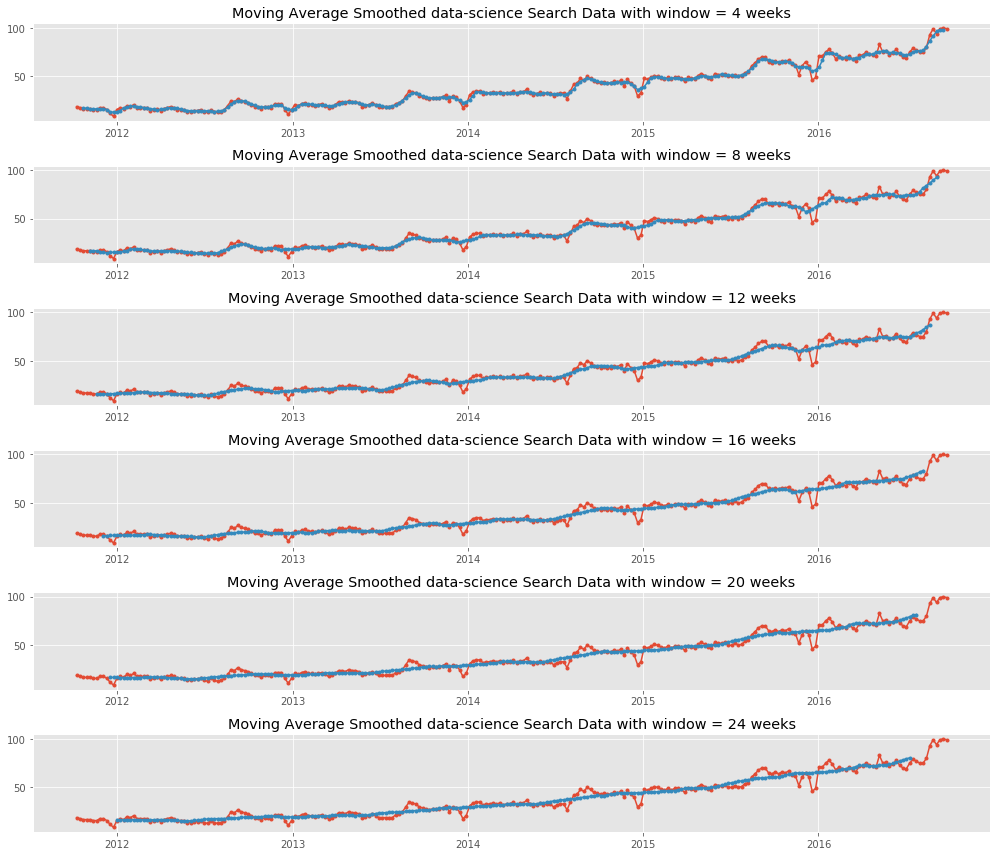

In [18]:
fig, axs = plt.subplots(6, figsize=(14, 12))

ds_series = load_google_trend_data('data-science')
for i, window in enumerate([4, 8, 12, 16, 20, 24]):
    axs[i].plot(ds_series.index, ds_series, marker='.')
    axs[i].plot(ds_series.index, 
                fit_moving_average_trend(ds_series, window=window),
               marker='.')
    axs[i].set_title("Moving Average Smoothed data-science Search Data with window = {} weeks".format(window))
    
plt.tight_layout()

When we have data that aligns with calendar regularities (quarterly, weekly, yearly), it is a good idea to choose the window so that an entire annual cycle is used in the smoothing.  This will average out any **seasonal** patterns in the data, as we will discuss below.

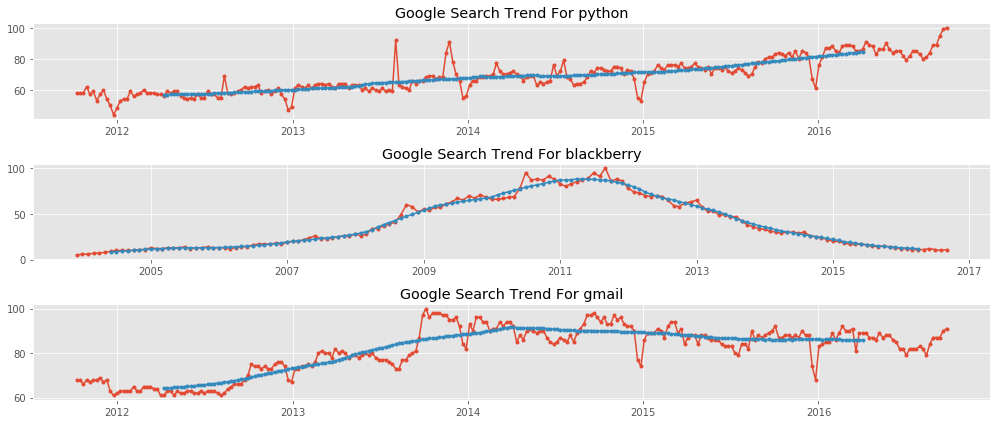

In [19]:
fig, axs = plt.subplots(3, figsize=(14, 6))
plot_moving_average_trend(axs[0], 'python', google_trends['python'], window=52)
plot_moving_average_trend(axs[1], 'blackberry', google_trends['blackberry'], window=12)
plot_moving_average_trend(axs[2], 'gmail', google_trends['gmail'], window=52)
plt.tight_layout()

## Seasonality

A **seasonal** pattern in a time series is one that tends to appear regularly with a fixed period

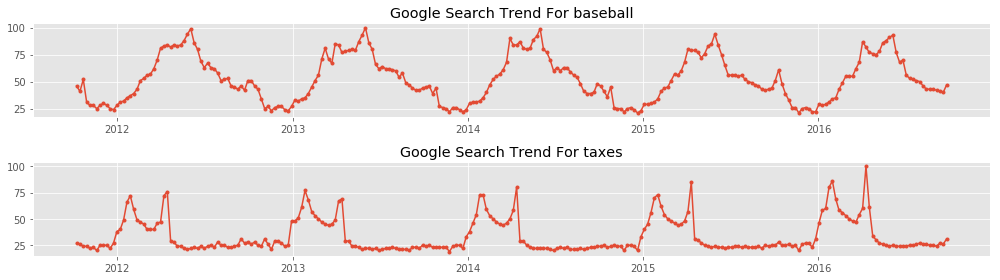

In [20]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_trend_data(axs[0], 'baseball', google_trends['baseball'])
plot_trend_data(axs[1], 'taxes', google_trends['taxes'])
plt.tight_layout()

Just like we can de**trend** a time series, we can also **deseasonalize** a time series.

The simplest method is to create dummy variables at regular intervals of the calender
  - A dummy for each month.
  - A dummy for each season.
  
and then fit a linear regression to the series using these dummy variables.

In [21]:
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict collinearity.
    return pd.get_dummies(month).iloc[:, :11]

In [22]:
def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

In [23]:
def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, seasons_average_trend, marker='.')

Here are linear regression models fit to the baseball and taxes trends with monthly dummy variables.

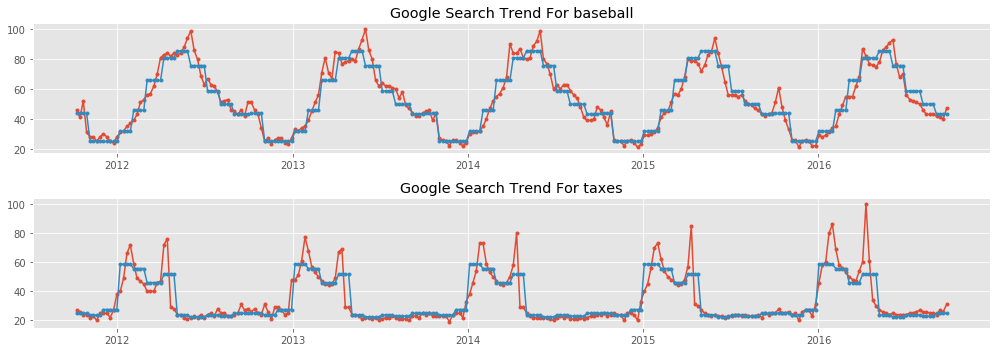

In [24]:
fig, axs = plt.subplots(2, figsize=(14, 5))

plot_seasonal_trend(axs[0], 'baseball', google_trends['baseball'])
plot_seasonal_trend(axs[1], 'taxes', google_trends['taxes'])
plt.tight_layout()

To deseasonalize, we simply subtract out the seasonal predictions.

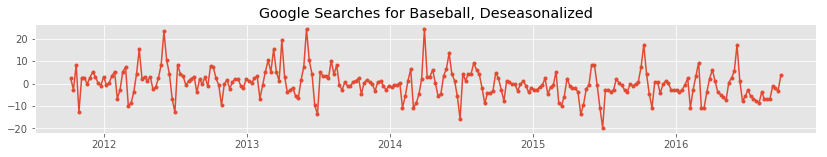

In [25]:
baseball_series = google_trends['baseball']
baseball_seasonal_trend = fit_seasonal_trend(baseball_series)
baseball_seasonal_detrended = baseball_series - baseball_seasonal_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(baseball_series.index, 
        baseball_seasonal_detrended,
        marker='.')
ax.set_title("Google Searches for Baseball, Deseasonalized");

**Question:** Have we removed the seasonality from these series?  What more could we do?

**Activity:** Deseasonalize the `taxes` series.

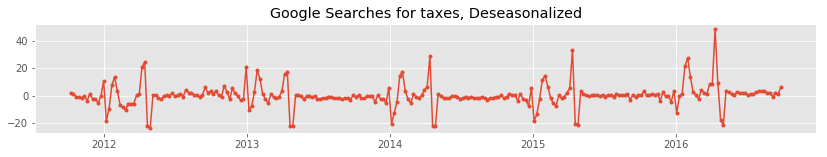

In [26]:
tax_series = google_trends['taxes']
tax_seasonal_trend = fit_seasonal_trend(tax_series)
tax_seasonal_detrended = tax_series - tax_seasonal_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(tax_series.index, 
        tax_seasonal_detrended,
       marker='.')
ax.set_title("Google Searches for taxes, Deseasonalized");

## Trend-Seasonal-Residual Decomposition

The **Classical Trend-Seasonal-Residual Decomposition** expresses a time series as the sum of three components:

$$ y_t = T_t + S_t + R_t $$

and is accomplished as follows.

Suppose, for definiteness, that we are working with *weekly* data, so that each $52$ observations forms a calendar year.  Then, the series is decomposed as follows:

1. Compute the trend component $T_t$ using a moving average with window width $52$ (or $12$ for monthly data).  Then detrend the series.
2. Compute the seasonal component $S_t$ of the detrended series $y_t - T_t$ by averaging together the observations that fall in the same week (or month, if monthly data).  **Note**, this is *equivalent* to fitting a linear regression to the detrended data with an indicator for each week, and then making predictions for each week of the original series.
3. The **remainder**, or **error**, or **residual** series $R_t$ is $y_t - T_t - S_t$.

Statsmodels implements the classical decomposition as `seasonal_decompose`.

In [27]:
python_decomposition = sm.tsa.seasonal_decompose(google_trends['python'])

In [28]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series, marker='.')
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend, marker='.')
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal, marker='.')
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid, marker='.')
    axs[3].set_title("Residual Component $R_t$")

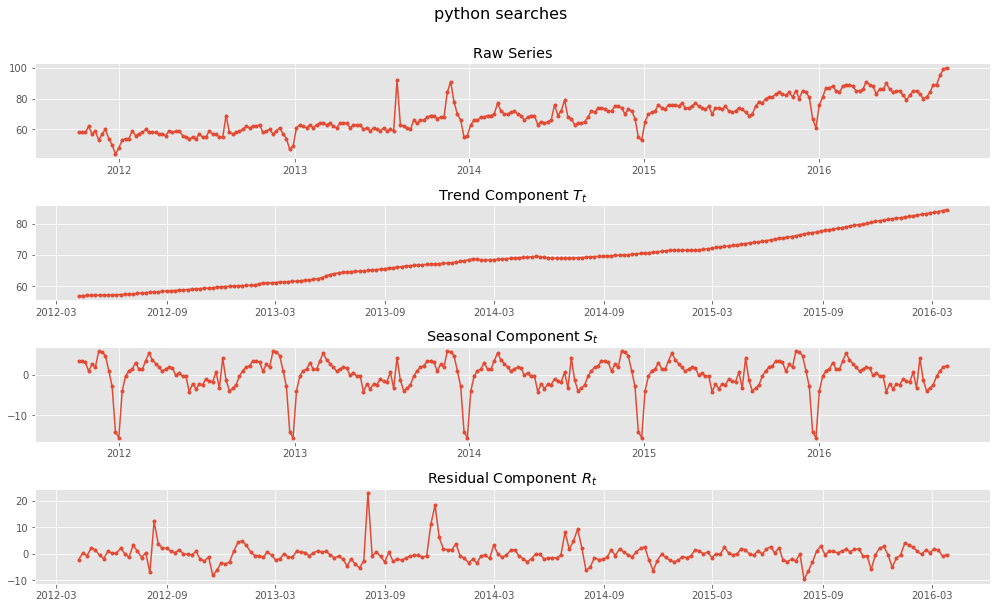

In [29]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, google_trends['python'], python_decomposition)
fig.suptitle("python searches", 
             horizontalalignment='center', 
             y=1.05, fontsize=16)
fig.tight_layout()

This decomposition validates our description of the series earlier as a general upwards trend, but with some seasonal behaviour (like a sharp drop off in queries around wintertime).

When the decomposition is working well, the residual component $R_t$ should show no seasonal or trend patterns.

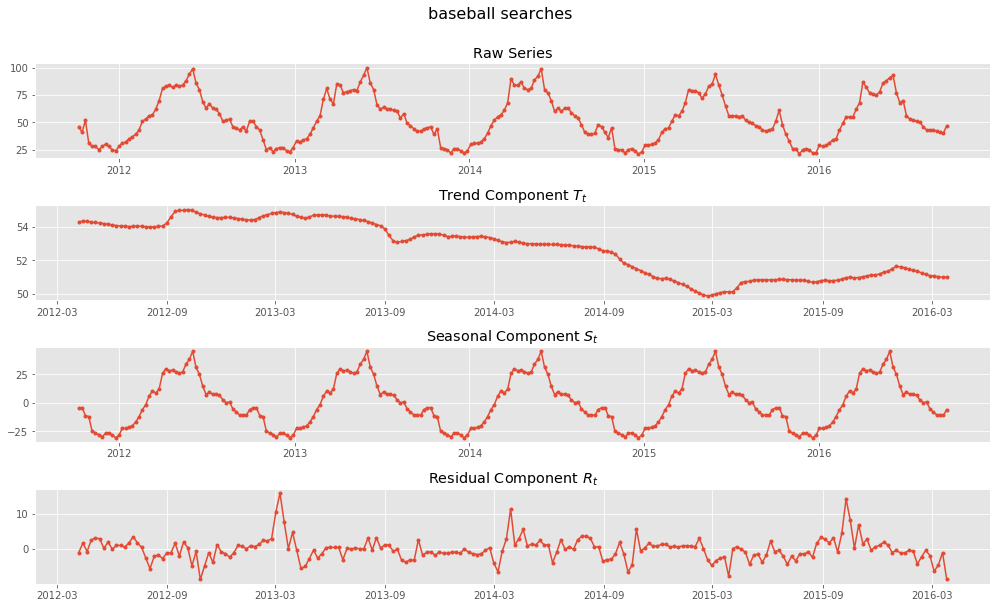

In [30]:
baseball_decomposition = sm.tsa.seasonal_decompose(google_trends['baseball'])

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, google_trends['baseball'], baseball_decomposition)
fig.suptitle("baseball searches", 
             horizontalalignment='center', 
             y=1.05, fontsize=16)
fig.tight_layout()

**Note:** The different components of the series are often shown on very different scales, so make sure to pay close attention to the $y$-axis labels.

Sometimes the classical decomposition is not powerful enough to capture the trend or seasonal components of a time series.

The gmail series decomposition shows some interesting behaviour in the residuals:

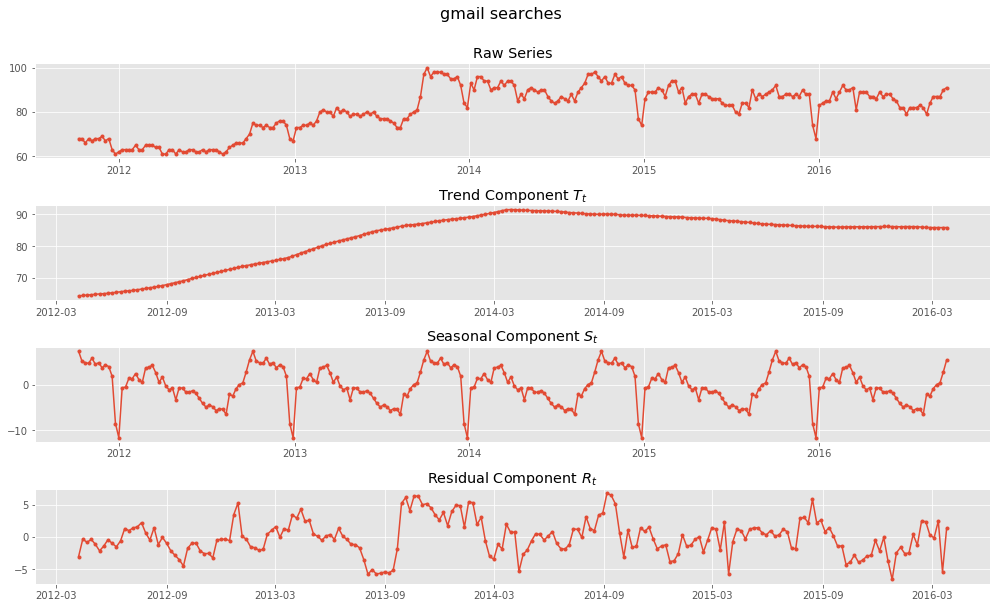

In [31]:
gmail_decomposition = sm.tsa.seasonal_decompose(google_trends['gmail'])

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, google_trends['gmail'], gmail_decomposition)
fig.suptitle("gmail searches", 
             horizontalalignment='center', 
             y=1.05, fontsize=16)
fig.tight_layout()

Around October 2013 the series showed a clear and sudden change in average level, which the trend component could not adapt to quickly enough.  Consequently, this discontinuity appears in the residual series.

A more sophisticated procedure should be used to decompose this series, which allows for a discontinuity in the observed series, or fits a more sophisticated model for the trend component.

**Activity:** Decompose the data science series.  What patterns do you see?  Is the decomposition appropriate?

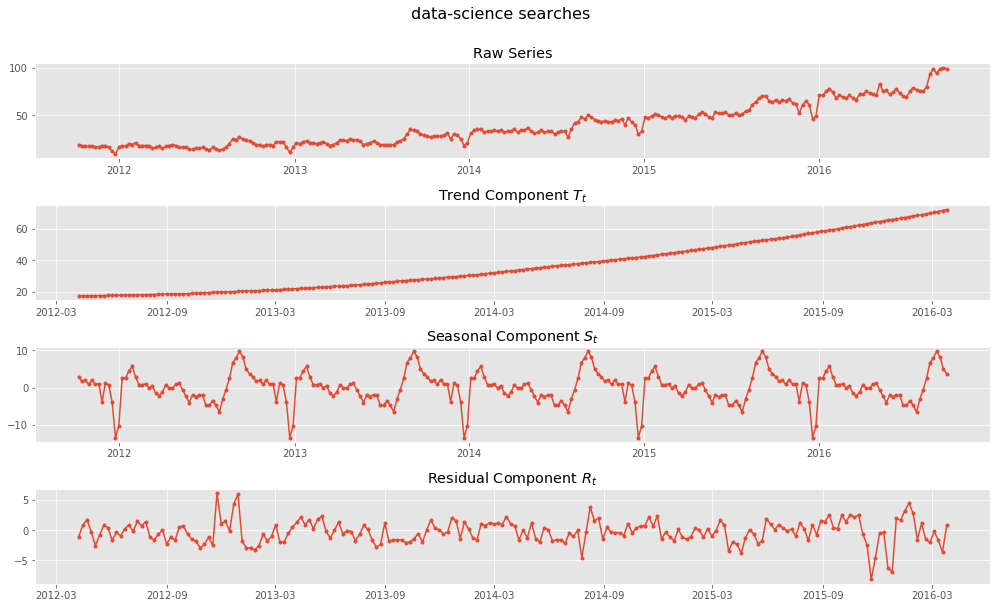

In [32]:
ds_decomposition = sm.tsa.seasonal_decompose(google_trends['data-science'])

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, google_trends['data-science'], ds_decomposition)
fig.suptitle("data-science searches", 
             horizontalalignment='center', 
             y=1.05, fontsize=16)
fig.tight_layout()